In [1]:
# IMPORT NECESSARY LIBRARIES
## For data wrangling
import pandas as pd
import numpy as np
import os

## For data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## For statistical testing
from scipy.stats import f_oneway, pearsonr, chi2_contingency, spearmanr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

## For data modelling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [2]:
## import extracted customer order details

customer_data = pd.read_csv('customer data for python.csv')

In [3]:
## Data Wrangling
#inspect the first three rows

customer_data.head(3)

,orderid,unitprice,quantity,discount,OrderDate,RequiredDate,ShippedDate,freight,ShipCountry,ProductName,...,country,ContactTitle,City,CategoryName,shippername,employee_fullname,Salary,Title,TitleOfCourtesy,RegionDescription
0,10293,50.0,12,0,1996-08-29 00:00:00,1996-09-26 00:00:00,1996-09-11 00:00:00,21.18,Mexico,Carnarvon Tigers,...,Mexico,Owner,Mxico D.F.,Seafood,Federal Shipping,Nancy Davolio,2954.55,Sales Representative,Ms.,Eastern ...
1,10293,3.6,10,0,1996-08-29 00:00:00,1996-09-26 00:00:00,1996-09-11 00:00:00,21.18,Mexico,Guaran Fantstica,...,Mexico,Owner,Mxico D.F.,Beverages,Federal Shipping,Nancy Davolio,2954.55,Sales Representative,Ms.,Eastern ...
2,10293,35.1,5,0,1996-08-29 00:00:00,1996-09-26 00:00:00,1996-09-11 00:00:00,21.18,Mexico,Vegie-spread,...,Mexico,Owner,Mxico D.F.,Condiments,Federal Shipping,Nancy Davolio,2954.55,Sales Representative,Ms.,Eastern ...


In [4]:
#inspect the last three rows

customer_data.tail(3)

,orderid,unitprice,quantity,discount,OrderDate,RequiredDate,ShippedDate,freight,ShipCountry,ProductName,...,country,ContactTitle,City,CategoryName,shippername,employee_fullname,Salary,Title,TitleOfCourtesy,RegionDescription
2152,10829,6.0,10,0,1998-01-13 00:00:00,1998-02-10 00:00:00,1998-01-23 00:00:00,154.72,UK,Konbu,...,UK,Marketing Manager,Cowes,Seafood,Speedy Express,Anne Dodsworth,2333.33,Sales Representative,Ms.,Northern ...
2153,10829,34.0,21,0,1998-01-13 00:00:00,1998-02-10 00:00:00,1998-01-23 00:00:00,154.72,UK,Camembert Pierrot,...,UK,Marketing Manager,Cowes,Dairy Products,Speedy Express,Anne Dodsworth,2333.33,Sales Representative,Ms.,Northern ...
2154,10970,7.0,40,0,1998-03-24 00:00:00,1998-04-07 00:00:00,1998-04-24 00:00:00,16.16,Spain,Filo Mix,...,Spain,Owner,Madrid,Grains/Cereals,Speedy Express,Anne Dodsworth,2333.33,Sales Representative,Ms.,Northern ...


In [48]:
## check the correspondence of non-null value.

delivery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   orderid          830 non-null    int64         
 1   delivery_status  830 non-null    object        
 2   ShippedDate      809 non-null    datetime64[ns]
 3   RequiredDate     830 non-null    datetime64[ns]
 4   OrderDate        830 non-null    datetime64[ns]
 5   freight          830 non-null    float64       
 6   shippername      830 non-null    object        
 7   Revenue          830 non-null    float64       
 8   CompanyName      830 non-null    object        
 9   year_orders      830 non-null    int32         
dtypes: datetime64[ns](3), float64(2), int32(1), int64(1), object(3)
memory usage: 61.7+ KB


In [6]:
## # check missing values

customer_data.isnull().sum()

,0
orderid,0
unitprice,0
quantity,0
discount,0
OrderDate,0
RequiredDate,0
ShippedDate,73
freight,0
ShipCountry,0
ProductName,0


In [7]:
## shape of the dataset

customer_data.shape

(2155, 21)

In [8]:
## change datatype of the dates

customer_data['OrderDate'] = pd.to_datetime(customer_data['OrderDate'])
customer_data['RequiredDate'] = pd.to_datetime(customer_data['RequiredDate'])
customer_data['ShippedDate'] = pd.to_datetime(customer_data['ShippedDate'])

## extract year, monthname and quarter from orderdate
## extract month and month_name
customer_data['month_orders'] = customer_data['OrderDate'].dt.month_name()

## extract year
customer_data['year_orders'] = customer_data['OrderDate'].dt.year

## extract quarters
customer_data['quarter_orders'] = customer_data['OrderDate'].dt.quarter

In [9]:
## check variables
customer_data['year_orders'].value_counts()

,count
year_orders,
1997,1059
1998,691
1996,405


In [10]:
## drop column
customer_data.drop(columns = ['country','Title', 'ContactTitle', 'TitleOfCourtesy', 'City'], inplace=True)

In [11]:
### create the revenue on each order
customer_data['Revenue'] = customer_data['unitprice'] * customer_data['quantity']

In [12]:
### create a categorical column for delivery_status

def delivery_status(row):
    if pd.isna(row['ShippedDate']):
        return 'Not shipped'
    elif row['ShippedDate'] > row['RequiredDate']:
        return 'Late'
    elif row['ShippedDate'] < row['RequiredDate']:
        return 'Early'
    elif row['ShippedDate'] == row['RequiredDate']:
        return 'Same day'

customer_data['delivery_status'] = customer_data.apply(delivery_status, axis=1)


In [13]:
## New dataframe showing delivery grouped by orders
# Group by 'OrderID' and aggregate based on delivery status

delivery = customer_data.groupby('orderid').agg({
    'delivery_status': 'first',
    'ShippedDate': 'first',
    'RequiredDate': 'first',
    'OrderDate': 'first',
    'freight': 'first',
    'shippername': 'first',
    'Revenue': 'sum',
    'CompanyName' : 'first',
    'year_orders' : 'first'
}).reset_index()

# Display the new dataframe
delivery


,orderid,delivery_status,ShippedDate,RequiredDate,OrderDate,freight,shippername,Revenue,CompanyName,year_orders
0,10248,Early,1996-07-16,1996-08-01,1996-07-04,32.38,Federal Shipping,440.0,Vins et alcools Chevalier,1996
1,10249,Early,1996-07-10,1996-08-16,1996-07-05,11.61,Speedy Express,1863.4,Toms Spezialitten,1996
2,10250,Early,1996-07-12,1996-08-05,1996-07-08,65.83,United Package,1813.0,Hanari Carnes,1996
3,10251,Early,1996-07-15,1996-08-05,1996-07-08,41.34,Speedy Express,670.8,Victuailles en stock,1996
4,10252,Early,1996-07-11,1996-08-06,1996-07-09,51.30,United Package,3730.0,Suprmes dlices,1996
...,...,...,...,...,...,...,...,...,...,...
825,11073,Not shipped,NaT,1998-06-02,1998-05-05,24.95,United Package,300.0,Pericles Comidas clsicas,1998
826,11074,Not shipped,NaT,1998-06-03,1998-05-06,18.44,United Package,244.3,Simons bistro,1998
827,11075,Not shipped,NaT,1998-06-03,1998-05-06,6.19,United Package,586.0,Richter Supermarkt,1998
828,11076,Not shipped,NaT,1998-06-03,1998-05-06,38.28,United Package,1057.0,Bon app',1998


In [14]:
# check basic descriptive statistics for total order details
# Select the relevant columns
selected_columns = customer_data[['unitprice', 'quantity', 'Revenue']]

# Get descriptive statistics
selected_columns.describe()


,unitprice,quantity,Revenue
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,628.519067
std,29.827418,19.022047,1036.466980
min,2.000000,1.000000,4.800000
25%,12.000000,10.000000,154.000000
50%,18.400000,20.000000,360.000000
75%,32.000000,30.000000,722.250000
max,263.500000,130.000000,15810.000000


In [15]:
# check basic descriptive statistics for each order
# Select the relevant columns
delivery_columns = delivery[['freight', 'Revenue']]

# Get descriptive statistics
delivery_columns.describe()

,freight,Revenue
count,830.000000,830.000000
mean,78.244205,1631.877819
std,116.779294,1990.613963
min,0.020000,12.500000
25%,13.380000,480.000000
50%,41.360000,1015.900000
75%,91.430000,2028.650000
max,1007.640000,17250.000000


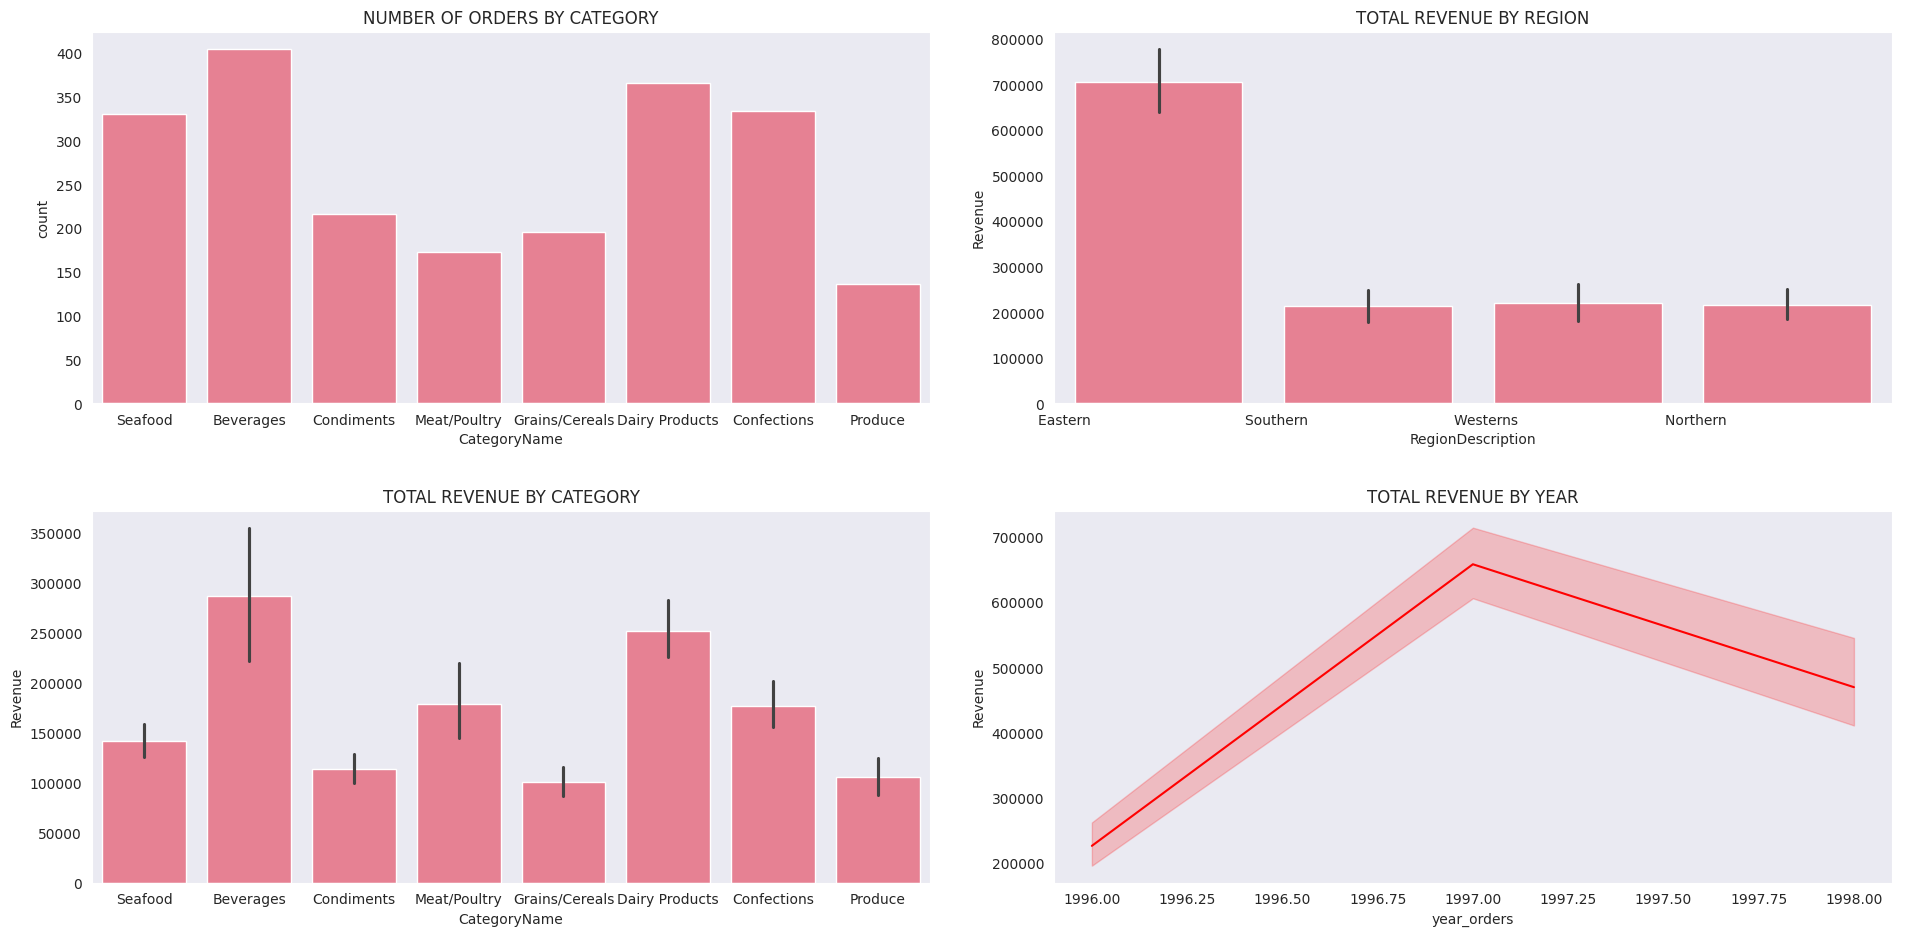

In [16]:
## Visualize data
sns.set_style('dark')
sns.set_palette('husl')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.countplot(data = customer_data, x = 'CategoryName', ax=axes[0,0])
sns.barplot(data =customer_data , x = 'RegionDescription', y = 'Revenue',estimator = sum, ax=axes[0,1])
sns.barplot(data = customer_data, x = 'CategoryName',y = 'Revenue', estimator = sum, ax=axes[1,0])
sns.lineplot(data=customer_data, x='year_orders', y='Revenue', estimator=np.sum, ax=axes[1,1], color='red'),

axes[0,0].set_title('NUMBER OF ORDERS BY CATEGORY')
axes[0,1].set_title('TOTAL REVENUE BY REGION')
axes[1,0].set_title('TOTAL REVENUE BY CATEGORY')
axes[1,1].set_title('TOTAL REVENUE BY YEAR')


fig.tight_layout(pad = 3)


**Sales Analysis**

Product Categories:
*   There are 8 product categories observed.
*   Total Orders by Category: Beverages and Dairy products lead in the number of orders, while Produce and Meat/Poultry have the fewest orders.

Revenue by Region:
*  Eastern Region: This region generates the highest revenue, significantly outperforming other regions.
*   Other Regions: The Western, Southern, and Northern regions have nearly identical revenue levels, trailing behind the Eastern region.

Total Revenue by Product:

*  Beverages and Dairy Products: These categories generate the most revenue overall.
*  Meat/Poultry: Despite being one of the least ordered categories, it still contributes significantly to sales.

*  Grains/Cereals: This category brings in the least revenue.

Sales Trend:
*   1997: Sales saw an increase during this year.
*   1998: There was a sharp decline in sales, but it’s important to note that the data for 1998 covers less than a full year. There remains potential for recovery in the third quarter of 1998.

These insights highlight key areas for strategic focus, such as boosting underperforming categories and regions, and capitalizing on the strengths of top-performing products and markets.

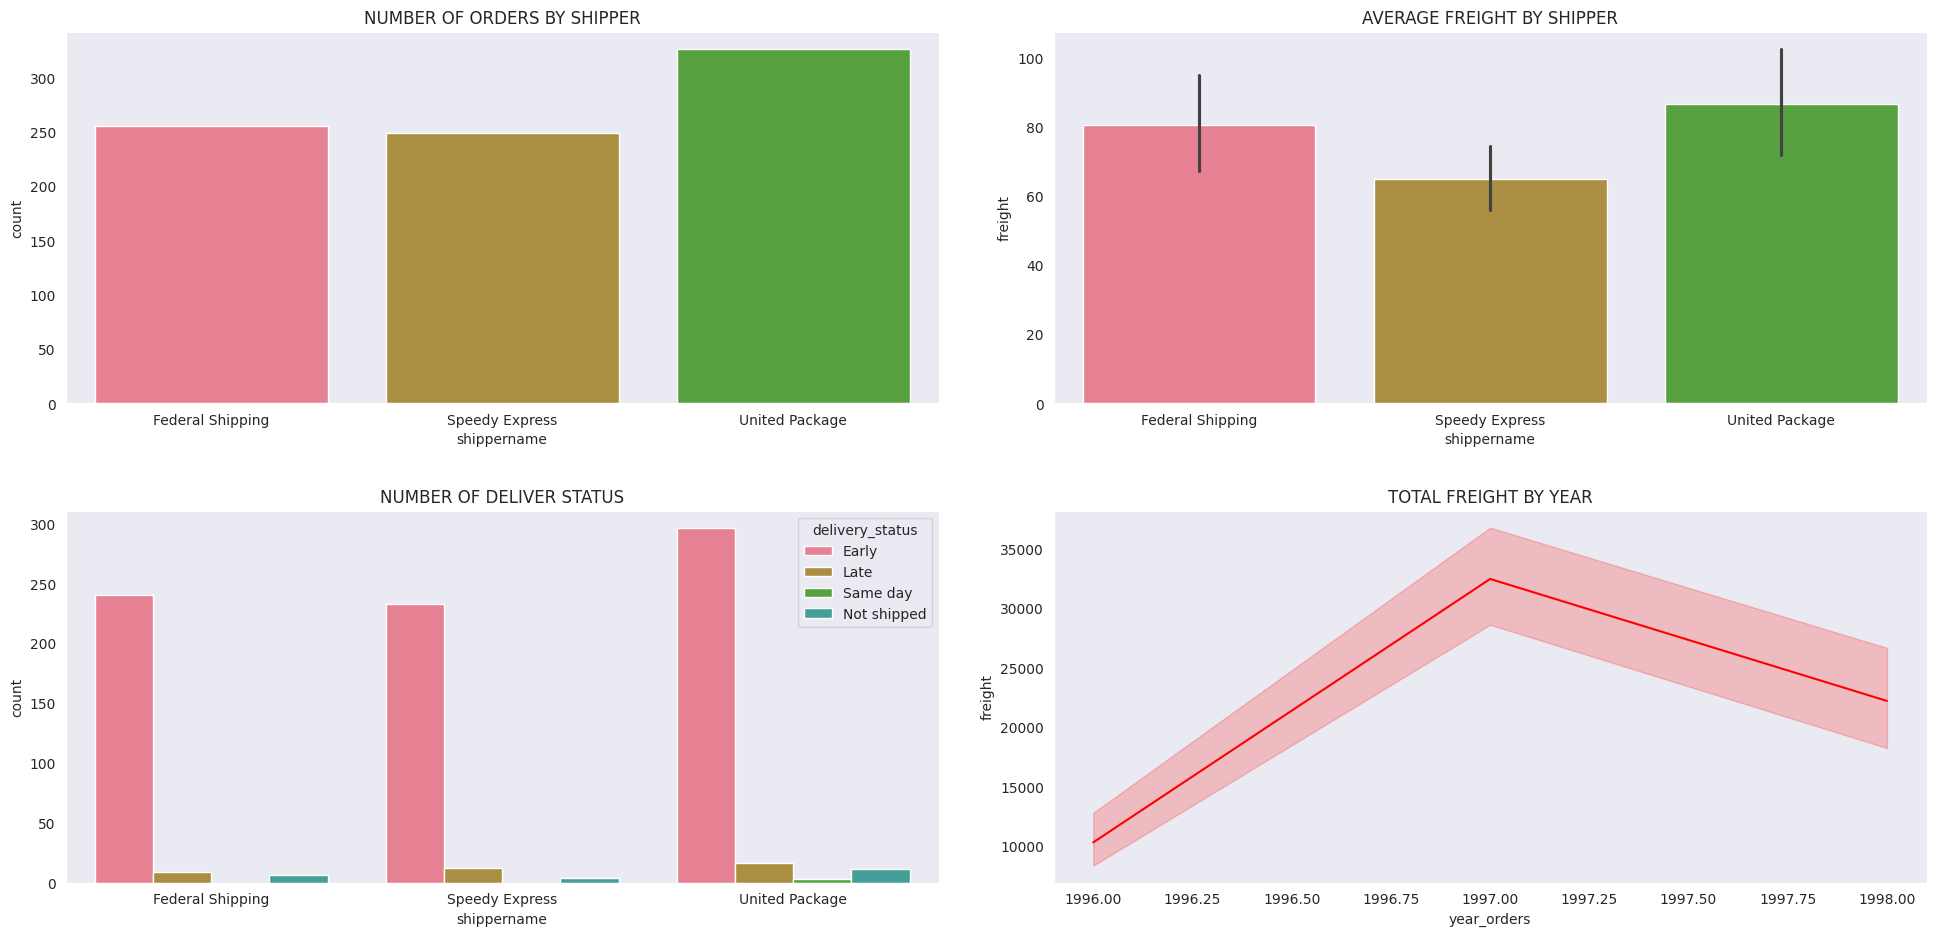

In [121]:
## Visualize data (operational)
sns.set_style('dark')
sns.set_palette('husl')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))
sns.countplot(data = delivery, x = 'shippername', hue ='shippername', ax=axes[0,0])
sns.barplot(data = delivery, x = 'shippername', y = 'freight',estimator = np.mean, hue ='shippername', ax=axes[0,1])
sns.countplot(data = delivery , x = 'shippername', hue = 'delivery_status', ax=axes[1,0])
sns.lineplot(data= delivery, x='year_orders', y='freight', estimator=np.sum, ax=axes[1,1], color='red'),

axes[0,0].set_title('NUMBER OF ORDERS BY SHIPPER')
axes[0,1].set_title('AVERAGE FREIGHT BY SHIPPER')
axes[1,0].set_title('NUMBER OF DELIVER STATUS')
axes[1,1].set_title('TOTAL FREIGHT BY YEAR')


fig.tight_layout(pad = 3)

**Operational Analysis**

Based on the analysis, Northwind Company utilizes three different shipping companies with varying levels of efficiency and cost:

United Package:

They handle the highest number of orders. This results in the highest average freight cost among the three shipping companies.

Speedy Express:

They manage the lowest number of orders. Consequently, they incur the lowest average freight cost.

Federal Shipping:

Their order volume is slightly higher than Speedy Express. However, they still experience a relatively high average freight cost.

**Overall Insight**

Freight Cost and Revenue Correlation: The analysis reveals a consistent trend between freight cost and revenue. As the freight cost increases, so does the revenue, indicating that freight costs have a significant impact on the company’s revenue stream.

This insight is crucial for strategic decision-making, as it highlights the importance of optimizing shipping strategies to balance cost and revenue. Identifying and addressing inefficiencies in the shipping process could lead to substantial cost savings and increased profitability.





In [18]:
## HYPOTHESIS TESTING
#1) Does freight cost impact sales?


## set our hypothesis
ho = 'There is no relationship between freight cost and Revenue'
h1 = 'There is a relationship between freight cost and Revenue'

## set the alpha value
alpha = 0.05

## set decision rule
def decision(p_value:float):

    if p_value < alpha:
        result = h1
    else:
        result = ho
    return f'{result} @ p_value = {round(p_value,4)}'


## compute the test
## compute the test

corr_coeff, corr_pvalue= spearmanr(delivery['freight'].values , delivery['Revenue'].values)

decision(p_value=corr_pvalue)


##decision

decision(p_value=corr_pvalue)


'There is a relationship between freight cost and Revenue @ p_value = 0.0'

In [19]:
corr_coeff

0.7745115222736957

**Hypothesis Testing Findings**

Based on the hypothesis testing conducted, the analysis indicates that freight cost significantly impacts sales. Here are the key findings:

P-value: The p-value obtained from the hypothesis test is less than 5%, which is typically considered statistically significant. This suggests that there is a strong evidence to reject the null hypothesis, indicating that freight cost does indeed have an impact on sales.

R-value: The correlation coefficient (r value) is 77.5%. This indicates a strong positive correlation between freight cost and sales. A high r-value close to 1 suggests that as freight cost increases, sales also tend to increase.

In [20]:
## CUSTOMER SEGMENTATION USING RFM (RECENCY, FREQUENCY AND MONETARY)
## RECENCY

day = '1998-06-06'
day = pd.to_datetime(day)
recency = delivery.groupby(["CompanyName"]).agg({"OrderDate": lambda x: (day - x.max()).days})
recency = recency.reset_index()

recency.head(3)

,CompanyName,OrderDate
0,Alfreds Futterkiste,58
1,Ana Trujillo Emparedados y helados,94
2,Antonio Moreno Taquera,129


In [21]:
## FREQUENCY

freq = delivery.groupby(["CompanyName"])[['orderid']].count()
freq = freq.reset_index()
freq

,CompanyName,orderid
0,Alfreds Futterkiste,6
1,Ana Trujillo Emparedados y helados,4
2,Antonio Moreno Taquera,7
3,Around the Horn,13
4,B's Beverages,10
...,...,...
84,Wartian Herkku,15
85,Wellington Importadora,9
86,White Clover Markets,14
87,Wilman Kala,7


In [22]:
## MONETARY

monetary = delivery.groupby(["CompanyName"])[['Revenue']].sum()
monetary = monetary.reset_index()
monetary


,CompanyName,Revenue
0,Alfreds Futterkiste,4596.20
1,Ana Trujillo Emparedados y helados,1402.95
2,Antonio Moreno Taquera,7515.35
3,Around the Horn,13806.50
4,B's Beverages,6089.90
...,...,...
84,Wartian Herkku,16617.10
85,Wellington Importadora,6480.70
86,White Clover Markets,29073.45
87,Wilman Kala,3161.35


In [77]:
## Merge the columns

recency.columns = ['CompanyName', 'Recency']
freq.columns = ['CompanyName', 'Frequency']
monetary.columns = ['CompanyName', 'Monetary']

RFM = recency.merge(freq, on='CompanyName').merge(monetary, on='CompanyName')


In [78]:
RFM

,CompanyName,Recency,Frequency,Monetary
0,Alfreds Futterkiste,58,6,4596.20
1,Ana Trujillo Emparedados y helados,94,4,1402.95
2,Antonio Moreno Taquera,129,7,7515.35
3,Around the Horn,57,13,13806.50
4,B's Beverages,53,10,6089.90
...,...,...,...,...
84,Wartian Herkku,52,15,16617.10
85,Wellington Importadora,89,9,6480.70
86,White Clover Markets,36,14,29073.45
87,Wilman Kala,60,7,3161.35


In [79]:
encoder = LabelEncoder()

cols = ['CompanyName']
for col in cols:
  RFM[col] = encoder.fit_transform(RFM[col])

In [80]:
# scale the dataset
scaler = StandardScaler()
scaleddata = scaler.fit_transform(RFM)

In [81]:
## To find number of clusters

inertia = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
  kmeans.fit(scaleddata)
  inertia.append(kmeans.inertia_)


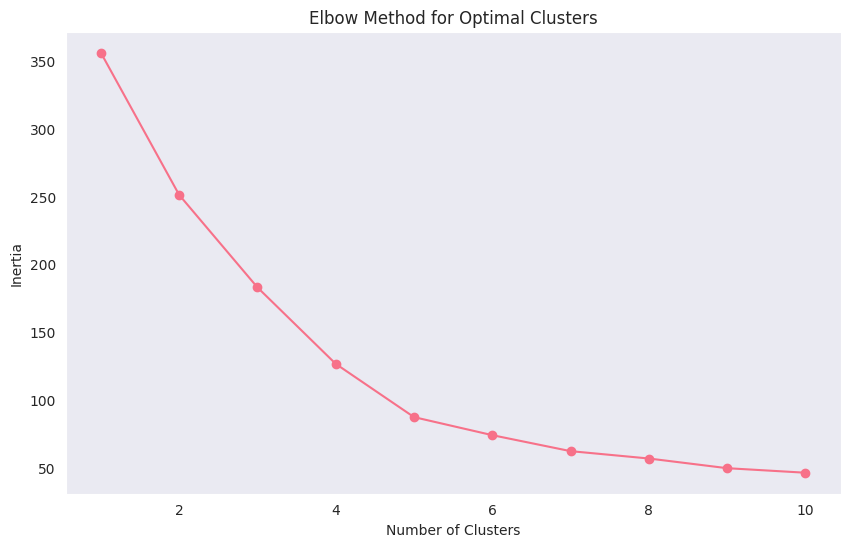

In [82]:
## Elbow Method plot

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [111]:
## clustering

kmeans = KMeans(n_clusters=3, n_init=7, random_state=40)
kmeans.fit(scaleddata)
RFM['Cluster'] = (kmeans.labels_ +1)

In [112]:
RFM

,CompanyName,Recency,Frequency,Monetary,Cluster,purchasepattern
0,0,58,6,4596.20,3,Average Spender
1,1,94,4,1402.95,3,Average Spender
2,2,129,7,7515.35,3,Average Spender
3,3,57,13,13806.50,3,Average Spender
4,4,53,10,6089.90,3,Average Spender
...,...,...,...,...,...,...
84,84,52,15,16617.10,1,Mini Spender
85,85,89,9,6480.70,1,Mini Spender
86,86,36,14,29073.45,1,Mini Spender
87,87,60,7,3161.35,1,Mini Spender


In [113]:
## mean of the clusters based on their recency, frequency and monetary value

group = RFM.groupby(['Cluster'])[[ 'Recency','Frequency' ,'Monetary']].mean()
group

,Recency,Frequency,Monetary
Cluster,,,
1,63.156863,9.745098,14819.597059
2,40.333333,29.666667,115464.486667
3,114.457143,6.971429,7207.590857


In [114]:
### group customers into high spender, average spender, mini spender, no loyalty

def func(row):
  if row["Cluster"] == 1:
    return "Average Spender"
  elif row["Cluster"] == 2:
    return " High Spender"
  elif row["Cluster"] == 3:
    return "No loyalty"

RFM["purchasepattern"] = RFM.apply(func, axis=1)

In [115]:
RFM

,CompanyName,Recency,Frequency,Monetary,Cluster,purchasepattern
0,0,58,6,4596.20,3,No loyalty
1,1,94,4,1402.95,3,No loyalty
2,2,129,7,7515.35,3,No loyalty
3,3,57,13,13806.50,3,No loyalty
4,4,53,10,6089.90,3,No loyalty
...,...,...,...,...,...,...
84,84,52,15,16617.10,1,Average Spender
85,85,89,9,6480.70,1,Average Spender
86,86,36,14,29073.45,1,Average Spender
87,87,60,7,3161.35,1,Average Spender


In [116]:

cu_p = RFM["purchasepattern"].value_counts()
cu_p

,count
purchasepattern,
Average Spender,51
No loyalty,35
High Spender,3


Text(0.5, 0, 'Purchase Pattern')

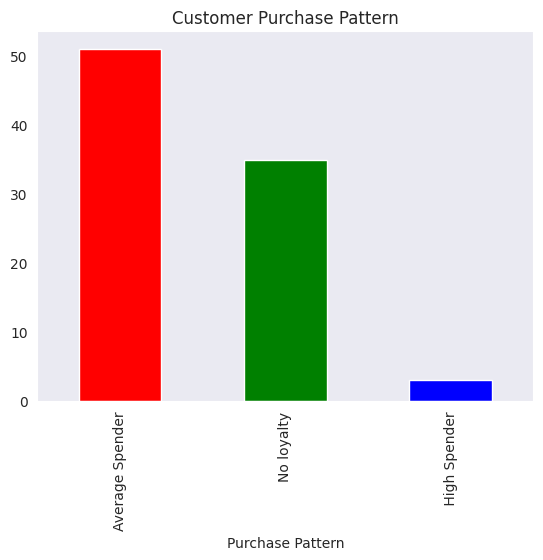

In [118]:
cu_p.plot(kind = 'bar', color = ["red", "green", "blue"])
plt.title("Customer Purchase Pattern")
plt.xlabel("Purchase Pattern")

**Customer Segmentation**

Based on the customer purchase pattern analysis, customers have been grouped into three distinct clusters:

High Spenders :

This group consists of approximately 3 customers who generate an average revenue of ₦115,000. They order frequently, with an average of 29 orders, and have an average recency of 42 days.

Average Spenders:

The largest group, comprising 51 customers, which makes up 57% of the total customer base. These customers have an average recency of about 75 days.

No Loyalty Customers:

This group represents 39% of the total customers.They have an average recency of approximately 114 days and place around 7 orders. These customers contribute the least to revenue.


**Based on the RFM analysis, you can segment your customers into different categories:**

High-Value Customers: Companies with high recency, frequency, and monetary scores. These customers are highly engaged and contribute significantly to revenue. They should be targeted with loyalty programs and special offers to retain them.

At-Risk Customers: Companies with low recency scores. These customers have not made recent purchases and may need re-engagement strategies such as targeted marketing campaigns or personalized offers.

Low-Value Customers: Companies with low frequency and monetary scores. These customers have minimal engagement and contribute less to revenue. They may need special incentives or targeted campaigns to increase their engagement.

